In [153]:
%matplotlib inline
import itertools
from collections import defaultdict, Counter
from functools import reduce
import re
import nltk
from math import log2
import pandas as pd
from Bio import SeqIO, SeqRecord, Seq
from tqdm import tqdm_notebook as tqdm
import concurrent.futures 
import sys, os
import glob
from functools import partial
import pickle
from operator import itemgetter as ig
import requests
import json
from time import sleep
import goatools
import wget
import matplotlib.pyplot as plt

In [12]:
def grouper(n, iterable):
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

In [13]:
chunksize = 100000
if not os.path.exists("mball_split"):
    os.mkdir("mball_split")
for n,r in enumerate(grouper(chunksize, tqdm(SeqIO.parse("Microbiota_database_all_unique.fasta", "fasta"), total=n_huba))):
    with open("mball_split/%05d.fasta" % n, "w") as fo:
        SeqIO.write(r, fo, "fasta")

HBox(children=(IntProgress(value=0, max=7361436), HTML(value='')))

In [14]:
bases = glob.glob("mball_split/*.fasta")

In [4]:
peps = [(r.name,str(r.seq)) for r in SeqIO.parse("peps737.fasta", "fasta")]

In [5]:
n_huba = !grep '>' Microbiota_database_all_unique.fasta | wc -l
n_huba = int(n_huba[0])

In [ ]:
found = defaultdict(list)
for r in tqdm(SeqIO.parse("Microbiota_database_all_unique.fasta", "fasta"), total=n_huba):
    for pn, ps in peps:
        if ps.lower() in str(r.seq).lower():
            found[pn].append(r.name)

In [ ]:
chunksize = 100000
if not os.path.exists("mcc_split"):
    os.mkdir("mcc_split")
for n,r in enumerate(grouper(chunksize, tqdm(SeqIO.parse("Microbiota_database_all_unique.fasta", "fasta"), total=n_huba))):
    with open("mcc_split/%05d.fasta" % n, "w") as fo:
        SeqIO.write(r, fo, "fasta")

In [6]:
def find_peps(peps, fname):
    found = defaultdict(list)
    for r in SeqIO.parse(fname, "fasta"):
        for pn, ps in peps:
            if ps.lower() in str(r.seq).lower():
                found[pn].append(r)
   # print(fname+" done!")
    return found

In [7]:
def _find_peps(a):
    return find_peps(a[0], a[1])

In [8]:
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=16, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

In [15]:
ress = parallel_process(list(itertools.zip_longest([peps], bases, fillvalue=peps)),  _find_peps, n_jobs=32)

HBox(children=(IntProgress(value=0, max=71), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [9]:
n_huba

7361436

In [16]:
#pickle.dump(found, open("1740_in_hubacon_stupid.pkl", "wb"))

74

In [19]:
len(ress[0])

26

In [22]:
ress[0]["new042"]

[SeqRecord(seq=Seq('mkkaiasacvvclalsvltgcnplhgtavsppnepetsahplnaesarlsedgq...sft', SingleLetterAlphabet()), id='gi|364564964|gb|EHM42703.1|', name='gi|364564964|gb|EHM42703.1|', description='gi|364564964|gb|EHM42703.1|', dbxrefs=[])]

In [23]:
pep_to_gi = defaultdict(list)
for record in ress:
    for pep, seqs in record.items():
        for s in seqs:
            pep_to_gi[pep].append(s.name)

In [25]:
pep_to_gi["new043"]

['gi|769157613|ref|WP_044931789.1|', 'gi|291073688|gb|EFE11052.1|']

In [28]:
dict(peps)['new042']

'TGIQEDIRA'

In [89]:
all_gis = list(set(reduce(lambda x,y:x+y, list(pep_to_gi.values()), [])))

In [29]:
from Bio import Entrez

In [30]:
Entrez.email = "anatoly.urban@gmail.com"

In [91]:
handle = Entrez.efetch(db="protein", id="769157613,291073688", retmode="xml")

In [92]:
record = Entrez.read(handle)
handle.close()

In [93]:
import pprint

In [61]:
record[0]['GBSeq_feature-table'][0]['GBFeature_quals']


[{'GBQualifier_value': 'Clostridiales', 'GBQualifier_name': 'organism'}, {'GBQualifier_value': 'taxon:186802', 'GBQualifier_name': 'db_xref'}]

In [139]:
def get_taxinfo(ids, batchsize=1024):
    result = dict()
    for g in grouper(batchsize, tqdm(ids)):
        ids_text = ",".join(g)
        handle = Entrez.efetch(db="protein", id=ids_text, retmode="xml")
        records = Entrez.read(handle)
        handle.close()
        for record, i in zip(records, g):
            taxon = ""
            taxonomy = ""
            for k in record['GBSeq_feature-table']:
                if k.get('GBFeature_key', "") == 'source':
                    for kk in k['GBFeature_quals']:
                        if kk.get('GBQualifier_value', "").startswith('taxon:'):
                            taxon = kk['GBQualifier_value'].split(":")[1]
            taxonomy = record['GBSeq_taxonomy']
            result[i] = (taxon, taxonomy)
    return result

In [137]:
all_gis_t = map(ig(1), map(lambda x: x.split("|"), all_gis))

In [140]:
taxinfo = get_taxinfo(all_gis_t)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

11264it [11:09, 16.83it/s]

In [215]:
len(taxinfo)

13007

In [142]:
#pickle.dump(taxinfo, open("taxinfo.pkl", "wb"))

In [149]:
phyla = []
for l in map(ig(1), taxinfo.values()):
    ll = l.split(";")
    if len(ll) > 1:
        phyla.append(ll[1].strip())

In [151]:
Counter(phyla)

Counter({'Actinobacteria': 847,
         'Bacteroidetes': 868,
         'Euryarchaeota': 4,
         'Firmicutes': 2596,
         'Fungi': 46,
         'Fusobacteria': 235,
         'Proteobacteria': 8273,
         'Spirochaetes': 24,
         'Synergistetes': 33,
         'Verrucomicrobia': 8})

In [175]:
from  plotnine import *

In [230]:
df = pd.DataFrame.from_dict(Counter(phyla), orient="index")

In [231]:
df.columns = ["count"]

In [232]:
df['spec']=list(df.index)

In [233]:
df.to_csv("wo_counts.csv")

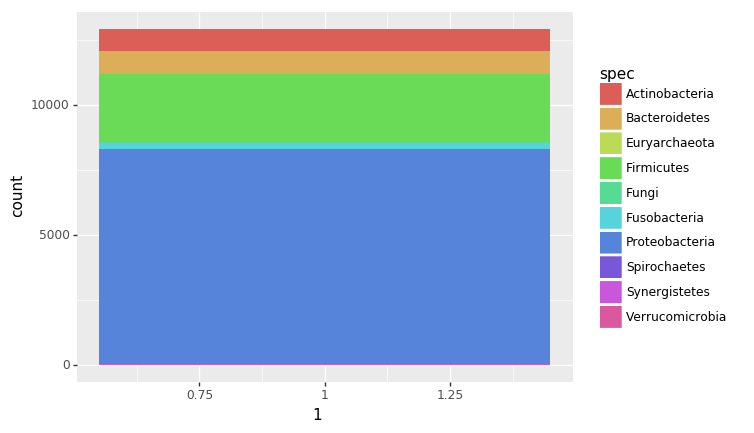

<ggplot: (-9223363242009601525)>

In [187]:
(plotnine.ggplot(df, plotnine.aes(x=1,y="count", fill="spec"))+plotnine.geom_col())

In [208]:
scount = {s.lower():int(c) for s,c in map(lambda x: x.split(), open("taxonomy_distribution_peps.tsv").readlines())}

In [209]:
scount

{'aaeeysmnlgflak': 412,
 'aaflfivpliklplivatapd': 1,
 'aagaelvgmedladqik': 9044,
 'aalestlaaiteslk': 10293,
 'aamfiifgffnaftfqsimllaps': 2,
 'aangngkrwyqlywprpqheevtasllgr': 2,
 'aaveegivigggaal': 1044,
 'aaveegivigggaalir': 507,
 'aaveegvvagggvalir': 12458,
 'aavlitgdvyd': 3,
 'adeqildigdasaqelaeilk': 3703,
 'adfdldlpegya': 3,
 'adhktdvaftksma': 5,
 'adigkkqvlkyqklar': 9,
 'adlqkviqdyge': 1,
 'adtssltpalvdqlpta': 1,
 'aeaalsatgiagpg': 10,
 'aedkkvldgadaf': 1,
 'aegqviaaaasagevlttt': 2,
 'aegyddqiyflir': 73,
 'aekqvtiaglsgvkp': 338,
 'aelslvddvf': 3,
 'aelsyltqdltvd': 58,
 'aerlerelaa': 19,
 'aevtaeapvveqp': 2,
 'afdddddvtd': 5,
 'afdqidnapeek': 16059,
 'afgenygvllgk': 539,
 'agaevkvteepe': 1,
 'agdnapmayielvdr': 11377,
 'agsgttgavcsalgrda': 9,
 'ahaeaqpgqtgkaafnavtwelglss': 2,
 'ahyvlmnveapqevidelettfr': 8989,
 'aiaqvgtisansdetvgk': 11544,
 'aidkpfllpiedvfsisgr': 14230,
 'aignaevidvak': 298,
 'aiisdvnasdedr': 4528,
 'akeaglmpmaew': 2,
 'aktgnkavdal': 2,
 'aldgvnfsveqgefvav': 9,
 'aleg

In [210]:
taxinfo

{'324014012': ('749530',
  'Bacteria; Proteobacteria; Gammaproteobacteria; Enterobacterales; Enterobacteriaceae; Escherichia'),
 '394288896': ('1155135',
  'Bacteria; Firmicutes; Bacilli; Bacillales; Staphylococcaceae; Staphylococcus'),
 '496065475': ('100883',
  'Bacteria; Firmicutes; Erysipelotrichia; Erysipelotrichales; Erysipelotrichaceae'),
 '392632210': ('997875',
  'Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales; Bacteroidaceae; Bacteroides'),
 '459561959': ('1159069',
  'Bacteria; Proteobacteria; Epsilonproteobacteria; Campylobacterales; Helicobacteraceae; Helicobacter'),
 '302311177': ('768713',
  'Bacteria; Firmicutes; Tissierellia; Tissierellales; Peptoniphilaceae; Finegoldia'),
 '553607778': ('1268987',
  'Bacteria; Proteobacteria; Gammaproteobacteria; Enterobacterales; Enterobacteriaceae; Escherichia'),
 '371955003': ('883158',
  'Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales; Prevotellaceae; Prevotella'),
 '226840694': ('457400',
  'Bacteria; Proteobacteria; Ga

In [211]:
pep_to_gi

defaultdict(list,
            {'new001': ['gi|568117030|gb|ETN39647.1|',
              'gi|671160181|ref|XP_008718432.1|'],
             'new002': ['gi|491502178|ref|WP_005359859.1|',
              'gi|149735688|gb|EDM51574.1|',
              'gi|490983621|ref|WP_004845368.1|',
              'gi|336015305|gb|EGN45123.1|',
              'gi|330409171|gb|EGG88626.1|',
              'gi|316897131|gb|EFV19204.1|',
              'gi|145848373|gb|EDK25291.1|'],
             'new003': ['gi|259036713|gb|EEW37968.1|',
              'gi|491797165|ref|WP_005605165.1|'],
             'new004': ['gi|392628850|gb|EIY22876.1|',
              'gi|404586508|gb|EKA91079.1|',
              'gi|404586074|gb|EKA90647.1|',
              'gi|404585807|gb|EKA90411.1|',
              'gi|404584130|gb|EKA88800.1|',
              'gi|404583147|gb|EKA87829.1|',
              'gi|260624648|gb|EEX47519.1|'],
             'new005': ['gi|496417580|ref|WP_009126427.1|',
              'gi|328524947|gb|EGF51999.1|'],
  

In [212]:
peps

[('new001', 'PDLWQLLD'),
 ('new002', 'MHLIDDHA'),
 ('new003', 'PSLTSTPN'),
 ('new004', 'PPYNPVTL'),
 ('new005', 'DPIWQLID'),
 ('new006', 'VATVSIPR'),
 ('new007', 'LESYLDNV'),
 ('new008', 'PEDDYLSL'),
 ('new009', 'INMAEIAA'),
 ('new010', 'QVMAEIAA'),
 ('new011', 'LSESASLLR'),
 ('new012', 'HSMESASLI'),
 ('new013', 'VDFAQARES'),
 ('new014', 'PDLKGNQEV'),
 ('new015', 'IEVIPAVES'),
 ('new016', 'GHGIGMGGD'),
 ('new017', 'SHTIIVACL'),
 ('new018', 'LLEVPEAAA'),
 ('new019', 'REEENEELE'),
 ('new020', 'IGTIKLLSD'),
 ('new021', 'PDIKADLID'),
 ('new022', 'PLQIVVEDD'),
 ('new023', 'KENLLIYLD'),
 ('new024', 'PGPGPQGTP'),
 ('new025', 'FAHLIVEKF'),
 ('new026', 'DGIGWIPID'),
 ('new027', 'WPLTLAILL'),
 ('new028', 'YNELFGAFK'),
 ('new029', 'EDVQFADSR'),
 ('new030', 'PDISVELID'),
 ('new031', 'DFATSMGFD'),
 ('new032', 'KAGTVYDLP'),
 ('new033', 'PLDILVAES'),
 ('new034', 'PLKNSGVEF'),
 ('new035', 'LDVMQAPVI'),
 ('new036', 'EGDVIAFGK'),
 ('new037', 'PEELENMLL'),
 ('new038', 'MTVADFEAR'),
 ('new039', 'EDVQFADDK

In [223]:
normint = []
for p, seq in peps:
    seq = seq.lower()
    p_gis = map(lambda x: x.split("|")[1],pep_to_gi[p])
    s_count = scount.get(seq, 1)
    for pg in p_gis:
        t = taxinfo.get(pg, ("", ""))[1].split(";")
        if len(t) > 1:
            t = t[1].strip()
            normint.append((t, s_count*1./len(pg)))

In [225]:
normint_agg = defaultdict(float)
for ph, c in normint:
    normint_agg[ph] += c

In [226]:
normint_agg

defaultdict(float,
            {'Actinobacteria': 3426284.405555515,
             'Bacteroidetes': 1906449.0936507909,
             'Euryarchaeota': 2.6666666666666665,
             'Firmicutes': 8687156.016666992,
             'Fungi': 15584.444444444454,
             'Fusobacteria': 638883.4444444467,
             'Proteobacteria': 15327389.138889588,
             'Spirochaetes': 39.77777777777778,
             'Synergistetes': 85216.0,
             'Verrucomicrobia': 18615.4})

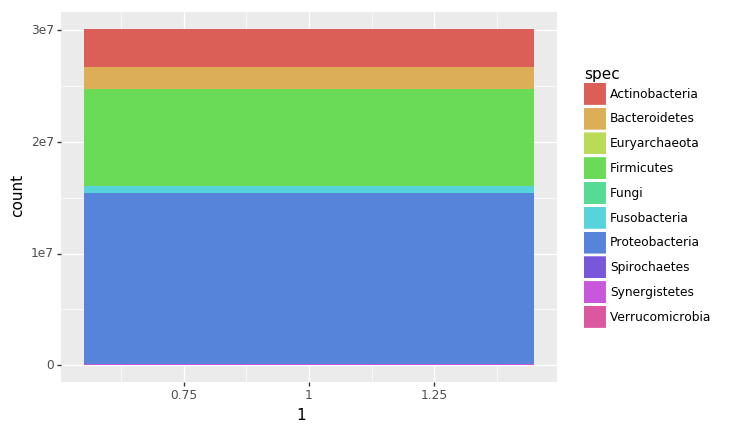

<ggplot: (-9223363242026576268)>

In [227]:
df = pd.DataFrame.from_dict(normint_agg, orient="index")
df.columns = ["count"]
df['spec']=list(df.index)
(plotnine.ggplot(df, plotnine.aes(x=1,y="count", fill="spec"))+plotnine.geom_col())

In [228]:
pd.wide_to_long

,count,spec
Verrucomicrobia,1.861540e+04,Verrucomicrobia
Actinobacteria,3.426284e+06,Actinobacteria
Firmicutes,8.687156e+06,Firmicutes
Fusobacteria,6.388834e+05,Fusobacteria
Euryarchaeota,2.666667e+00,Euryarchaeota
Spirochaetes,3.977778e+01,Spirochaetes
Fungi,1.558444e+04,Fungi
Bacteroidetes,1.906449e+06,Bacteroidetes
Proteobacteria,1.532739e+07,Proteobacteria
Synergistetes,8.521600e+04,Synergistetes


In [229]:
df.to_csv("counts.csv")